In [1]:
import os
print(os.listdir("../input"))

['train label.csv', 'dataset']


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [3]:
torch.cuda.set_device(0)
device = torch.device('cuda:0')

## 1. ResNet

In [4]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, data_type='train'):
        self.data_type = data_type
        self.transform_fn = transforms.Compose([
            transforms.Resize((350, 350)),
            transforms.ToTensor()
        ])
        if self.data_type == 'train':
            self.frame = pd.read_csv(csv_file).values
        elif self.data_type == 'test':
            self.frame = os.listdir('../input/dataset/image/test')
        else:
            raise 'Not support data_type %s' % self.data_type

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, i):
        if self.data_type == 'train':
            img = Image.open('../input/dataset/image/train/%s' % self.frame[i, 0]).convert('RGB')
            feature = self.transform_fn(img)
            label = self.frame[i, 1]
            return (feature, label)
        elif self.data_type == 'test':
            img = Image.open('../input/dataset/image/test/%s' % self.frame[i]).convert('RGB')
            feature = self.transform_fn(img)
            return (feature, 0)
        return None

In [5]:
batch_size = 64

trainset = ImageDataset('../input/train label.csv', 'train')
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = ImageDataset(None, 'test')
testloader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
def train(trainloader, model, loss_fn, optimizer,device):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    average_loss = total_loss / (batch_idx + 1)
    return average_loss

def evaluate(testloader, model, loss_fn, device):
    with torch.no_grad():
        model.eval()
        correct = 0.0
        total_loss = 0
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).cpu().sum().detach().numpy()
            loss = loss_fn(outputs, target)
            total_loss += loss.item()
        accuracy = correct*100.0 / len(testloader.dataset)
        average_loss = total_loss / (batch_idx + 1)
    return average_loss, accuracy

In [7]:
def fit(train_loader, model, loss_fn, optimizer, scheduler, n_epochs, device):
    train_accs = []
    train_losses = []

    print('Fit start')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss= train(train_loader, model, loss_fn, optimizer, device=device)
        _, train_accuracy = evaluate(train_loader, model, loss_fn, device=device)
        
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, train_loss, train_accuracy)
        print(message)
        print("Cost:", time.time() - start_time)

        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        scheduler.step()
    print('Fit end')
    return train_accs, train_losses

In [8]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 59119530.11it/s]


Fit start
Epoch: 1/30. Train set: Average loss: 0.6783, Accuracy: 88.9491
Cost: 245.8003008365631
Epoch: 2/30. Train set: Average loss: 0.2970, Accuracy: 92.7071
Cost: 497.5570938587189
Epoch: 3/30. Train set: Average loss: 0.1955, Accuracy: 92.3841
Cost: 738.3637852668762
Epoch: 4/30. Train set: Average loss: 0.1336, Accuracy: 92.8497
Cost: 982.6039950847626
Epoch: 5/30. Train set: Average loss: 0.0949, Accuracy: 96.6220
Cost: 1218.4251017570496
Epoch: 6/30. Train set: Average loss: 0.0709, Accuracy: 97.9666
Cost: 1452.3085570335388
Epoch: 7/30. Train set: Average loss: 0.0257, Accuracy: 99.8717
Cost: 1684.6923298835754
Epoch: 8/30. Train set: Average loss: 0.0095, Accuracy: 99.8765
Cost: 1916.434635400772
Epoch: 9/30. Train set: Average loss: 0.0066, Accuracy: 99.9002
Cost: 2147.653678894043
Epoch: 10/30. Train set: Average loss: 0.0053, Accuracy: 99.9192
Cost: 2378.4302971363068
Epoch: 11/30. Train set: Average loss: 0.0046, Accuracy: 99.9097
Cost: 2610.2387969493866
Epoch: 12/30. T

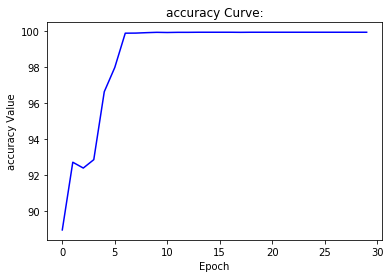

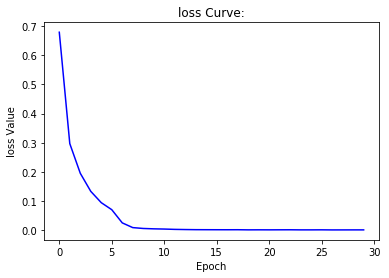

In [9]:
n_epochs = 30
learning_rate = 0.01

model = torchvision.models.resnet34(pretrained=True).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
train_accs, train_losses = fit(trainloader, model, loss_fn, optimizer, scheduler, n_epochs, device)
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')

In [10]:
def get_test_result(testloader, model, device):
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(testloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            if batch_idx == 0:
                result = predicted
            else:
                result = torch.cat([result, predicted], 0)
    return result

In [11]:
result = get_test_result(testloader, model, device)
arr = result.cpu().numpy()
df = pd.DataFrame({ 'Image': testloader.dataset.frame, 'Cloth_label': arr })
print(df)
df.to_csv('./resnet.csv', index=False)
print('Finish')

                  Image  Cloth_label
0      1284435479_0.jpg            6
1      1349231750_0.jpg            6
2      1091302340_0.jpg            7
3      1161240451_0.jpg            6
4      1062697695_0.jpg            6
5      1190892145_0.jpg            5
6      1303701329_0.jpg            3
7      1044877955_0.jpg            3
8      1018025143_0.jpg            5
9      1489565201_0.jpg            4
10     1029014607_0.jpg            5
11     1036137089_0.jpg            3
12     1264603468_0.jpg            7
13     1082599717_0.jpg            7
14     1330526512_0.jpg            7
15     1482292533_0.jpg            3
16     1114667779_0.jpg            4
17     1076129978_0.jpg            7
18     1016487823_0.jpg            7
19     1036522015_0.jpg            0
20     1167034175_0.jpg            0
21     1421717323_0.jpg            5
22     1016504505_0.jpg            3
23     1486465210_0.jpg            1
24     1309775983_0.jpg            5
25     1267915461_0.jpg            7
2